In [2]:
from PIL import Image
import requests
from io import BytesIO


url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [3]:
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import numpy as np

In [4]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

In [5]:
import random
import numpy as np
from scipy.spatial.distance import cdist, cityblock, cosine

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid
    """
    return cdist(X, centroids, metric=self.metric)


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(axis=1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)
    for k in range(self.K):
            if np.any(mask == k):
                new_centroids[k] = X[mask == k].mean(axis=0)
    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks 
    """
    centroids = self.init_centroids(X)
    for _ in range(self.I):
        new_centroids = self.update_clusters(X, centroids)
        delta = np.linalg.norm(new_centroids - centroids)
        if delta < self.E:
            break
        centroids = new_centroids
    return centroids

In [6]:
m = 3 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(28900, 3, 3, 3)

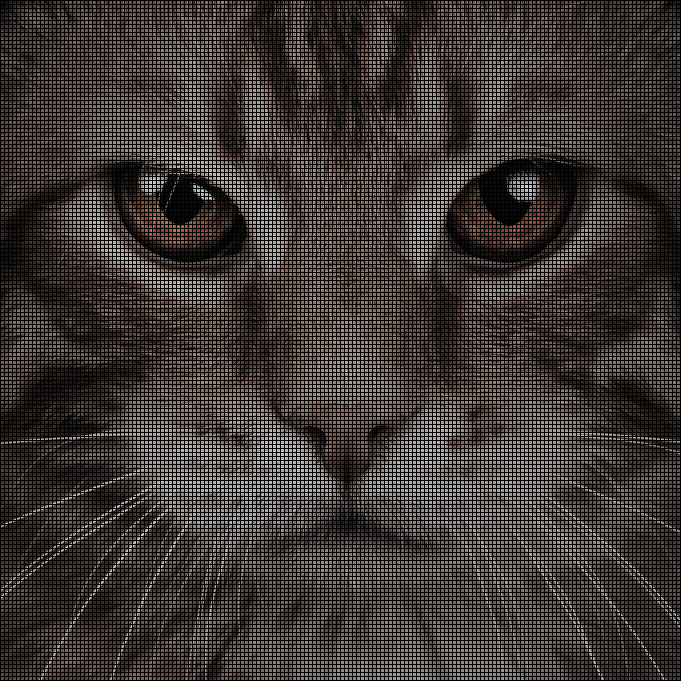

In [7]:
visualize_patches(patches, padding=1)

In [8]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(28900, 27)

In [9]:
# initialize KMeans algo euclidean distance
kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric="euclidean")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)


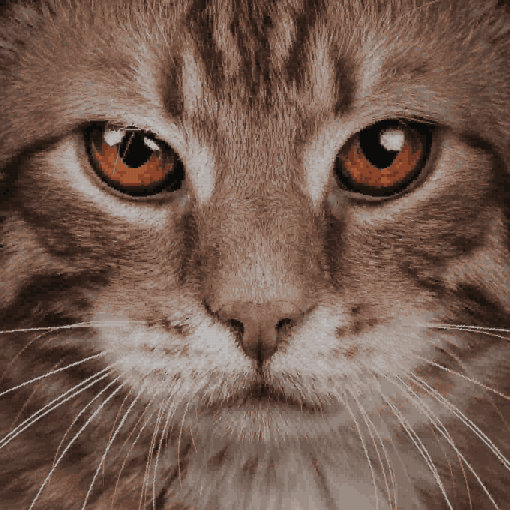

In [10]:
visualize_patches(predicted.reshape(-1,3,m, m))

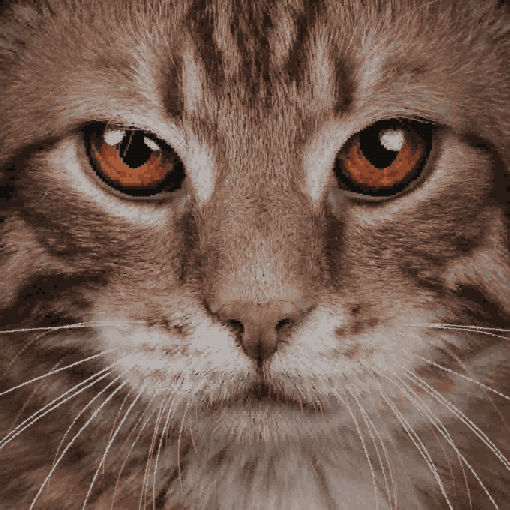

In [11]:
# Manhatten distance
kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric="cityblock")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m, m))

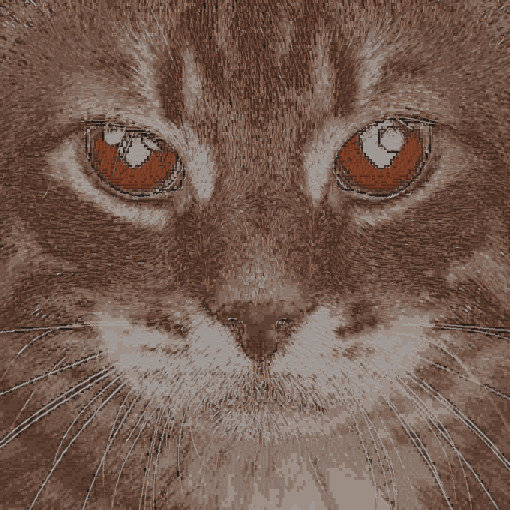

In [12]:
kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric="cosine")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m, m))
    

In [13]:
import os
from IPython.display import display

def calculate_compression_sizes(image_path, m_values, k_values):
    with Image.open(image_path) as img:
        W, H = img.size
        original_size = W * H * 3

    results = []

    for m in m_values:
        num_patches = (W // m) * (H // m)

        for k in k_values:
            centroids_size = k * 3 * 3  
            allocation_size = num_patches * 1
            compressed_size = centroids_size + allocation_size
            results.append({
                'm': m,
                'k': k,
                'original_size': original_size,
                'compressed_size': compressed_size,
                'compression_rate': compressed_size / original_size
            })
            
    return results

m_values = [3, 5, 10]  
k_values = [64, 128, 256]

image_path = BytesIO(response.content)

compression_results = calculate_compression_sizes(image_path, m_values, k_values)
compression_results



[{'m': 3,
  'k': 64,
  'original_size': 3499200,
  'compressed_size': 130176,
  'compression_rate': 0.03720164609053498},
 {'m': 3,
  'k': 128,
  'original_size': 3499200,
  'compressed_size': 130752,
  'compression_rate': 0.03736625514403292},
 {'m': 3,
  'k': 256,
  'original_size': 3499200,
  'compressed_size': 131904,
  'compression_rate': 0.03769547325102881},
 {'m': 5,
  'k': 64,
  'original_size': 3499200,
  'compressed_size': 47232,
  'compression_rate': 0.013497942386831276},
 {'m': 5,
  'k': 128,
  'original_size': 3499200,
  'compressed_size': 47808,
  'compression_rate': 0.013662551440329218},
 {'m': 5,
  'k': 256,
  'original_size': 3499200,
  'compressed_size': 48960,
  'compression_rate': 0.013991769547325103},
 {'m': 10,
  'k': 64,
  'original_size': 3499200,
  'compressed_size': 12240,
  'compression_rate': 0.0034979423868312758},
 {'m': 10,
  'k': 128,
  'original_size': 3499200,
  'compressed_size': 12816,
  'compression_rate': 0.003662551440329218},
 {'m': 10,
  'k'

In [14]:
def calc_distoriton(data: np.ndarray, centroids:np.ndarray, kmeans) -> float:
    distortion = 0
    assigned_centroids = kmeans.calc_mask(data, centroids)
    for i, point in enumerate(data):
        centroid = centroids[assigned_centroids[i]]
        squared_distance = np.sum((point - centroid) ** 2)
        distortion += squared_distance
    return distortion

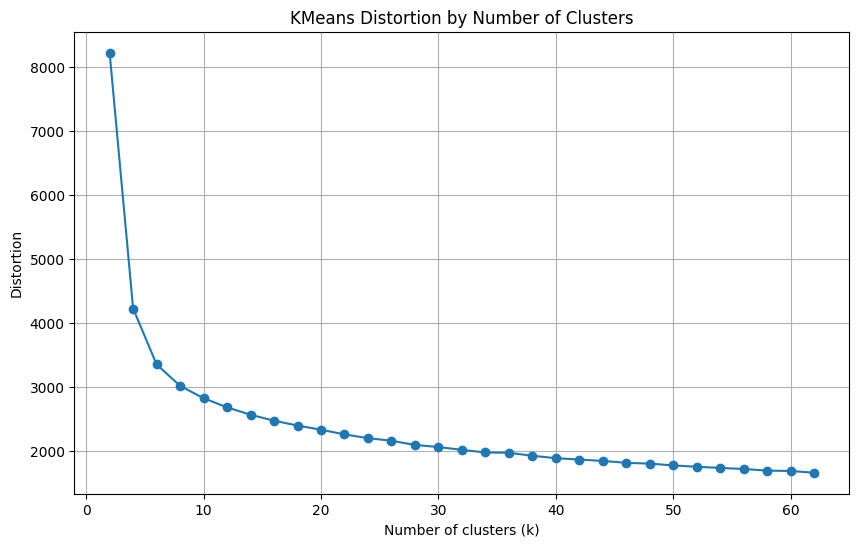

In [15]:
import matplotlib.pyplot as plt

k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
for k in k_range:
    kmeans = KMeans(num_clusters=k, num_features=data.shape[1])
    centroids = kmeans.fit(data)
    distortion = calc_distoriton(data, centroids, kmeans)
    distortions.append(distortion)

plt.figure(figsize=(10, 6))
plt.plot(k_range, distortions, marker='o')
plt.title('KMeans Distortion by Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()

In [19]:
comp_rate_k10 = calculate_compression_sizes(BytesIO(response.content), [3], [10])
comp_rate_k10

([{'m': 3,
   'k': 10,
   'original_size': 3499200,
   'compressed_size': 129690,
   'compression_rate': 0.03706275720164609}],
 [])